In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from darts import TimeSeries
from pykalman import KalmanFilter
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import pymannkendall as mk
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import kurtosis, skew
import scipy
######  Load data #####3
Katleho = pd.read_csv('Wind.csv')
Katleho['Date'] = pd.to_datetime(Katleho['Date'], infer_datetime_format=True)
Hlompho = Katleho.set_index(['Date']).asfreq('H')
print(Hlompho)

                         Wind
Date                         
2019-04-01 00:00:00   746.888
2019-04-01 01:00:00   937.058
2019-04-01 02:00:00   982.304
2019-04-01 03:00:00   980.428
2019-04-01 04:00:00  1035.222
...                       ...
2023-10-21 19:00:00  2407.113
2023-10-21 20:00:00  2406.191
2023-10-21 21:00:00  2291.848
2023-10-21 22:00:00  2219.364
2023-10-21 23:00:00  2217.836

[39960 rows x 1 columns]


In [13]:
###### Log-transformation of the dataset 
Hlompho['Wind.log'] = np.log1p(Hlompho['Wind'])
print(Hlompho)

                         Wind  Wind.log
Date                                   
2019-04-01 00:00:00   746.888  6.617253
2019-04-01 01:00:00   937.058  6.843812
2019-04-01 02:00:00   982.304  6.890918
2019-04-01 03:00:00   980.428  6.889009
2019-04-01 04:00:00  1035.222  6.943337
...                       ...       ...
2023-10-21 19:00:00  2407.113  7.786599
2023-10-21 20:00:00  2406.191  7.786216
2023-10-21 21:00:00  2291.848  7.737550
2023-10-21 22:00:00  2219.364  7.705426
2023-10-21 23:00:00  2217.836  7.704738

[39960 rows x 2 columns]


In [14]:
#########  Summary statistics
Hlompho[["Wind.log"]].describe()

,Wind.log
count,39960.000000
mean,6.707174
std,0.639036
min,3.035097
25%,6.337646
50%,6.798615
75%,7.166349
max,8.040197


In [16]:
# Compute kurtosis and skewness
kurt = kurtosis(Hlompho['Wind.log'])
skewness = skew(Hlompho['Wind.log'])
print("Kurtosis:", kurt)
print("Skewness:", skewness)

Kurtosis: 0.7827186787364928
Skewness: -0.7826887420035188


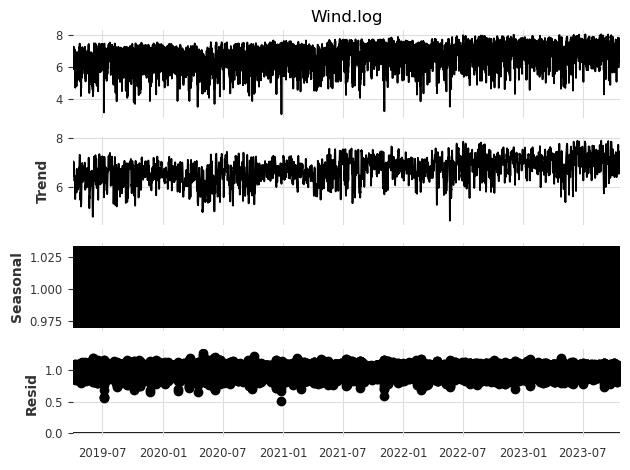

In [15]:
###### Perfom Clasiscal decomposistion   #####
result = seasonal_decompose(Hlompho["Wind.log"], model='multiplicative',extrapolate_trend='freq')
result.plot()
pyplot.show()

In [17]:
# Extract the components
Trend = result.trend
Seasonal = result.seasonal
Cyclical = result.resid
print(Cyclical)

Date
2019-04-01 00:00:00    0.939002
2019-04-01 01:00:00    0.978369
2019-04-01 02:00:00    0.990783
2019-04-01 03:00:00    0.993757
2019-04-01 04:00:00    1.003650
                         ...   
2023-10-21 19:00:00    1.018188
2023-10-21 20:00:00    1.021894
2023-10-21 21:00:00    1.022642
2023-10-21 22:00:00    1.024837
2023-10-21 23:00:00    1.030352
Freq: H, Name: resid, Length: 39960, dtype: float64


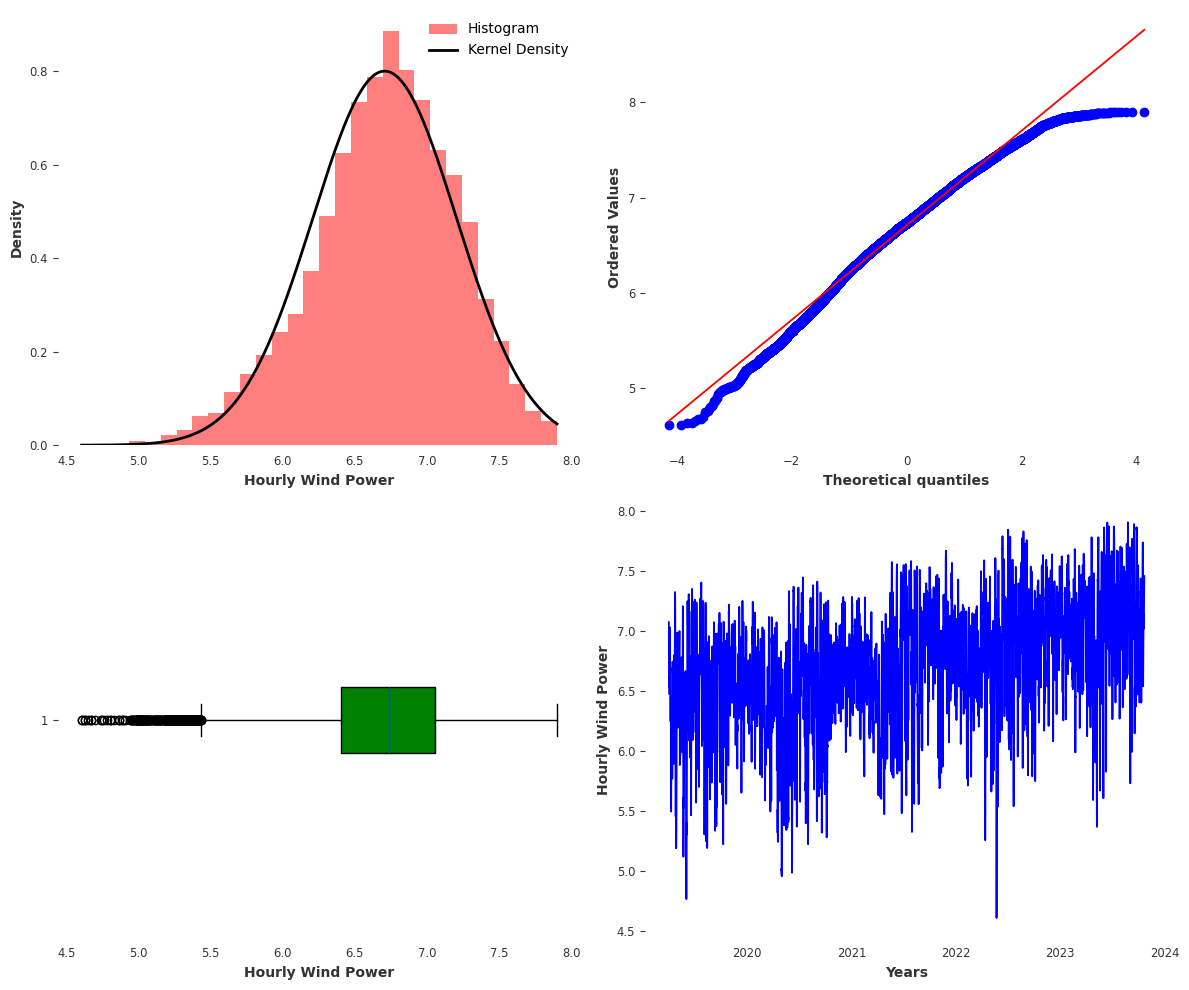

In [22]:
########  Exploratot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Plotting Histogram
axes[0, 0].hist(Trend, bins=30, density=True, alpha=0.5, color='red', label='Histogram')
xmin, xmax = min(Trend), max(Trend)
x = np.linspace(xmin, xmax, 1000)
pdf = stats.norm.pdf(x, np.mean(Trend), np.std(Trend))
axes[0, 0].plot(x, pdf, linewidth=2, label='Kernel Density',color="black")
axes[0, 0].set_title('')
axes[0, 0].set_xlabel('Hourly Wind Power')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Plotting QQ Plot
stats.probplot(Trend, dist='norm', plot=axes[0, 1])
axes[0, 1].set_title('')
axes[0, 1].get_lines()[0].set_markerfacecolor('blue')  

# Plotting Boxplot
axes[1, 0].boxplot(Trend, vert=False, patch_artist=True, boxprops=dict(facecolor='green'))
axes[1, 0].set_title('')
axes[1, 0].set_xlabel('Hourly Wind Power')

# Plotting Original Series
axes[1, 1].plot(Trend, color = "blue")
axes[1, 1].set_title('')
axes[1, 1].set_xlabel('Years')
axes[1, 1].set_ylabel('Hourly Wind Power')

for ax in axes.flatten():
    ax.grid(False)

plt.tight_layout()
plt.show()

In [23]:
########   Mann Kendall Non-Parametric trend Test   ######
mk.original_test(Trend)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=92.23594622934895, Tau=0.3076204686380116, s=245598282.0, var_s=7090065226500.0, slope=1.919167859482861e-05)

In [25]:
# Create hierarchical features
Hlompho['Hour'] = Hlompho['Wind.log'].index.hour
Hlompho['Day'] = Hlompho['Wind.log'].index.day
Hlompho['Week'] = Hlompho['Wind.log'].index.isocalendar().week
Hlompho['Month'] = Hlompho['Wind.log'].index.month
Hlompho['Quarter'] = Hlompho['Wind.log'].index.quarter
Hlompho['Half_Year'] = (Hlompho['Wind.log'].index.month <= 6).astype(int) + 1
Hlompho['Year'] = Hlompho['Wind.log'].index.year
# Display the DataFrame with the new features
print(Hlompho.head())

                         Wind  Wind.log  Hour  Day  Week  Month  Quarter  \
Date                                                                       
2019-04-01 00:00:00   746.888  6.617253     0    1    14      4        2   
2019-04-01 01:00:00   937.058  6.843812     1    1    14      4        2   
2019-04-01 02:00:00   982.304  6.890918     2    1    14      4        2   
2019-04-01 03:00:00   980.428  6.889009     3    1    14      4        2   
2019-04-01 04:00:00  1035.222  6.943337     4    1    14      4        2   

                     Half_Year  Year  
Date                                  
2019-04-01 00:00:00          2  2019  
2019-04-01 01:00:00          2  2019  
2019-04-01 02:00:00          2  2019  
2019-04-01 03:00:00          2  2019  
2019-04-01 04:00:00          2  2019  


In [26]:
columns_to_filter = ['Wind.log']
Hlompho_filtered= Hlompho[columns_to_filter]
print(Hlompho_filtered)

                     Wind.log
Date                         
2019-04-01 00:00:00  6.617253
2019-04-01 01:00:00  6.843812
2019-04-01 02:00:00  6.890918
2019-04-01 03:00:00  6.889009
2019-04-01 04:00:00  6.943337
...                       ...
2023-10-21 19:00:00  7.786599
2023-10-21 20:00:00  7.786216
2023-10-21 21:00:00  7.737550
2023-10-21 22:00:00  7.705426
2023-10-21 23:00:00  7.704738

[39960 rows x 1 columns]


In [27]:
#######  Initialize Kalman Filter:
kf = KalmanFilter(initial_state_mean=Hlompho_filtered.iloc[0].values,
                  n_dim_obs=len(columns_to_filter))
#####  Apply Kalman Filter:  Iterate through your data and update the filter at each time step.
filtered_state_means, _ = kf.filter(Hlompho_filtered.values)
####  Merge Filtered Data Back: Once you have the filtered  merge it back into your DataFrame.
Hlompho_filtered.loc[:, columns_to_filter] = filtered_state_means

C:\Users\katle\AppData\Local\Temp\ipykernel_7964\1552885133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hlompho_filtered.loc[:, columns_to_filter] = filtered_state_means


In [28]:
# Splitting a time series into 80% for training, 20% for testing
split_percentage = 0.8
# Calculate the index to split at
split_index = int(len(Hlompho_filtered) * split_percentage)
# Split the data
train_data = Hlompho_filtered.iloc[:split_index]
test_data = Hlompho_filtered.iloc[split_index:]

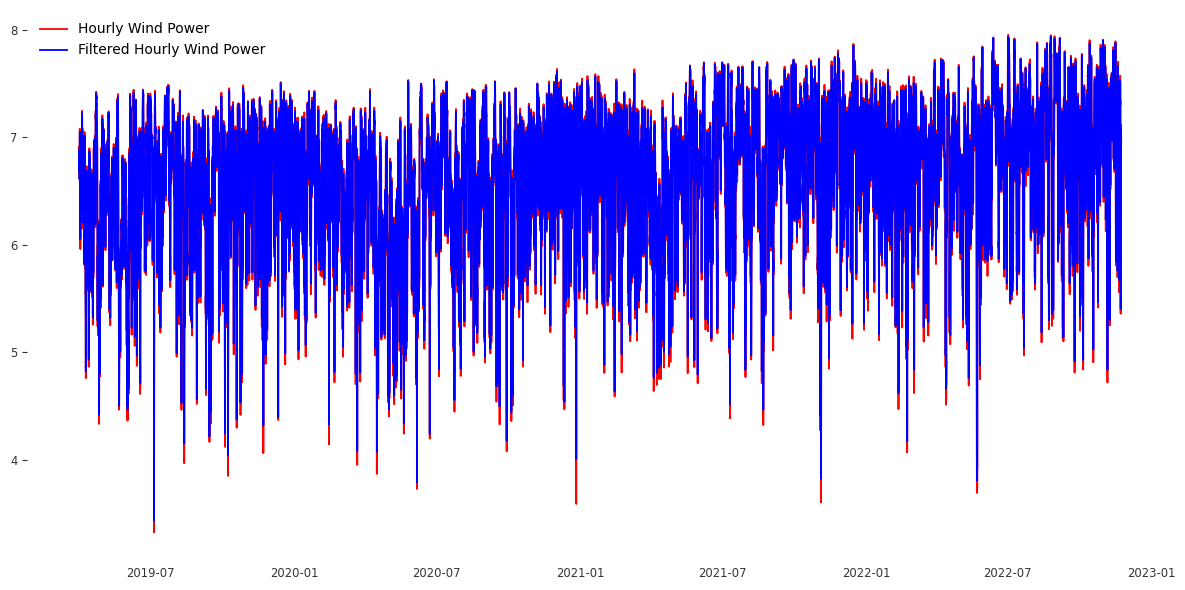

In [31]:
# Initialize Kalman Filter
initial_state_mean = train_data.iloc[0].values
kf = KalmanFilter(initial_state_mean=initial_state_mean, n_dim_obs=len(train_data.columns))

# Train Kalman Filter
filtered_state_means, _ = kf.filter(train_data.values)

# Access Filtered Results
train_data_filtered = pd.DataFrame(filtered_state_means, index=train_data.index, columns=train_data.columns)

# Visualize Training Results
plt.figure(figsize=(12, 6))

# Iterate over columns and plot original vs filtered data
for column in train_data.columns:
    plt.subplot(len(train_data.columns), 1, train_data.columns.get_loc(column) + 1)
    plt.plot(train_data.index, train_data[column], label=f'Hourly Wind Power', color='red')
    plt.plot(train_data.index, train_data_filtered[column], label=f'Filtered Hourly Wind Power', linestyle='-', color='blue')
    plt.grid(False)
    plt.title(f'')
    plt.legend()

plt.tight_layout()
plt.show()

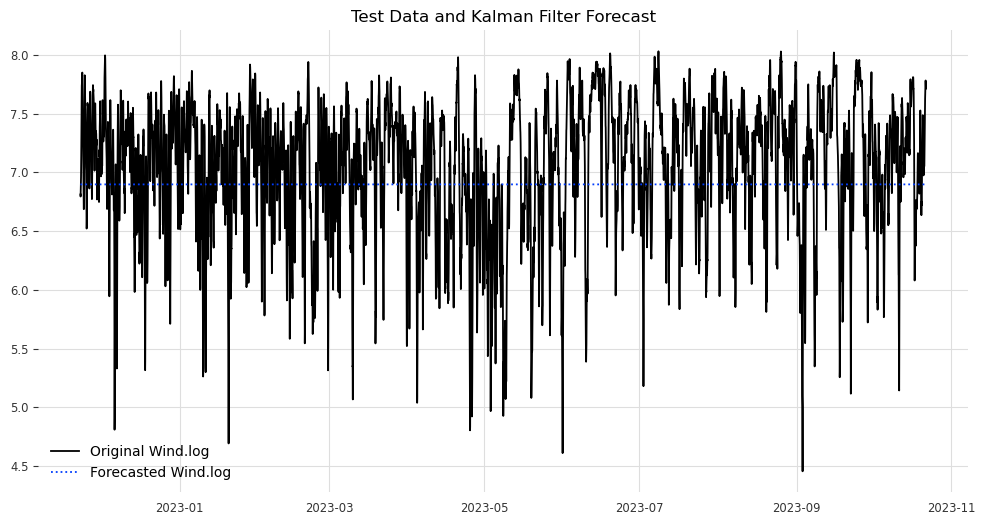

In [34]:
# Forecasting on Test Data
n_forecast_steps = len(test_data)
forecasted_state_means = []
filtered_state_covariances = []

# Use the last observation in the training data as the initial state
current_state = train_data.values[-1]
current_state_covariance = np.eye(len(train_data.columns))  # Initial covariance matrix

for _ in range(n_forecast_steps):
    # Predict the next state
    current_state, current_state_covariance = kf.filter_update(current_state, current_state_covariance)

    # Save the forecasted state and covariance
    forecasted_state_means.append(current_state)
    filtered_state_covariances.append(current_state_covariance)

# Convert the lists to NumPy arrays
forecasted_state_means = np.array(forecasted_state_means)
filtered_state_covariances = np.array(filtered_state_covariances)

# Access Forecasted Results
test_data_forecasted = pd.DataFrame(forecasted_state_means, index=test_data.index, columns=test_data.columns)


In [35]:
# Assuming you have the forecasted results in test_data_forecasted

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data.values, test_data_forecasted, multioutput='raw_values')
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data.values, test_data_forecasted, multioutput='raw_values')
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data.values - test_data_forecasted) / test_data.values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): [0.33316195]
Mean Absolute Error (MAE): [0.475927]
Mean Absolute Percentage Error (MAPE): Wind.log    6.893173
dtype: float64%
Root Mean Squared Error (RMSE): [0.57720183]


C:\Users\katle\.conda\envs\Makatjane\lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [37]:
columns_to_filter1 = ['Wind.log', 'Hour', 'Day', 'Week', 'Month', 'Week','Quarter','Half_Year','Year']
Makatjane= Hlompho[columns_to_filter1]
print(Makatjane)

                     Wind.log  Hour  Day  Week  Month  Week  Quarter  \
Date                                                                   
2019-04-01 00:00:00  6.617253     0    1    14      4    14        2   
2019-04-01 01:00:00  6.843812     1    1    14      4    14        2   
2019-04-01 02:00:00  6.890918     2    1    14      4    14        2   
2019-04-01 03:00:00  6.889009     3    1    14      4    14        2   
2019-04-01 04:00:00  6.943337     4    1    14      4    14        2   
...                       ...   ...  ...   ...    ...   ...      ...   
2023-10-21 19:00:00  7.786599    19   21    42     10    42        4   
2023-10-21 20:00:00  7.786216    20   21    42     10    42        4   
2023-10-21 21:00:00  7.737550    21   21    42     10    42        4   
2023-10-21 22:00:00  7.705426    22   21    42     10    42        4   
2023-10-21 23:00:00  7.704738    23   21    42     10    42        4   

                     Half_Year  Year  
Date                    

In [38]:
# Assuming 'target_column' is the column you're trying to predict
target_column = 'Wind.log'
X = Makatjane.drop(columns=target_column)
y = Makatjane[target_column]

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you have your training and testing sets ready to use
print("Training set:")
print(X_train, y_train)
print("\nTesting set:")
print(X_test, y_test)

Training set:
                     Hour  Day  Week  Month  Week  Quarter  Half_Year  Year
Date                                                                       
2022-07-04 02:00:00     2    4    27      7    27        3          1  2022
2020-08-25 02:00:00     2   25    35      8    35        3          1  2020
2023-02-16 18:00:00    18   16     7      2     7        1          2  2023
2023-02-12 09:00:00     9   12     6      2     6        1          2  2023
2020-02-26 10:00:00    10   26     9      2     9        1          2  2020
...                   ...  ...   ...    ...   ...      ...        ...   ...
2019-12-18 01:00:00     1   18    51     12    51        4          1  2019
2020-07-14 04:00:00     4   14    29      7    29        3          1  2020
2023-08-07 22:00:00    22    7    32      8    32        3          1  2023
2019-05-06 20:00:00    20    6    19      5    19        2          2  2019
2021-01-18 03:00:00     3   18     3      1     3        1          2  202

In [39]:
# Assuming you've already split your data into X_train, X_test, y_train, and y_test

# Initialize the GBDT model
gbdt_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)

# Fit the model to the training set
gbdt_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gbdt_model.predict(X_test)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) on Testing Set: {mse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on Testing Set: {mae}")

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE) on Testing Set: {mape}%")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) on Testing Set: {rmse}")

Mean Squared Error (MSE) on Testing Set: 0.30034691855362056
Mean Absolute Error (MAE) on Testing Set: 0.4243378561695325
Mean Absolute Percentage Error (MAPE) on Testing Set: 6.684800943040161%
Root Mean Squared Error (RMSE) on Testing Set: 0.548039157865221


In [40]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Kalman Filter
initial_state_mean = X_train.iloc[0].values
kf = KalmanFilter(initial_state_mean=initial_state_mean, n_dim_obs=len(X_train.columns))

# Train Kalman Filter
filtered_state_means_train, _ = kf.filter(X_train.values)
filtered_state_means_test, _ = kf.filter(X_test.values)

# Access Filtered Results
X_train_filtered = pd.DataFrame(filtered_state_means_train, index=X_train.index, columns=X_train.columns)
X_test_filtered = pd.DataFrame(filtered_state_means_test, index=X_test.index, columns=X_test.columns)

# Initialize the GBDT model
gbdt_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=62)

# Fit the GBDT model to the filtered training set
gbdt_model.fit(X_train_filtered, y_train)

# Make predictions on the testing set
y_pred_gbdt = gbdt_model.predict(X_test_filtered)


In [30]:
# Calculate Mean Squared Error (MSE)
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)
print(f"Mean Squared Error (MSE) of GBDT Model: {mse_gbdt}")

# Calculate Mean Absolute Error (MAE)
mae_gbdt = mean_absolute_error(y_test, y_pred_gbdt)
print(f"Mean Absolute Error (MAE) of GBDT Model: {mae_gbdt}")

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_gbdt = mean_absolute_percentage_error(y_test, y_pred_gbdt)
print(f"Mean Absolute Percentage Error (MAPE) of GBDT Model: {mape_gbdt}%")

# Calculate Root Mean Squared Error (RMSE)
rmse_gbdt = np.sqrt(mse_gbdt)
print(f"Root Mean Squared Error (RMSE) of GBDT Model: {rmse_gbdt}")


Mean Squared Error (MSE) of GBDT Model: 0.009769411466476462
Mean Absolute Error (MAE) of GBDT Model: 0.07733409271980027
Mean Absolute Percentage Error (MAPE) of GBDT Model: 0.7696223268346459%
Root Mean Squared Error (RMSE) of GBDT Model: 0.09884033319691138
